In [1]:
library(tidyverse)
library(reshape2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.5.2     ✔ purrr   1.0.1
✔ tibble  3.3.0     ✔ dplyr   1.1.4
✔ tidyr   1.3.0     ✔ stringr 1.5.1
✔ readr   2.1.3     ✔ forcats 1.0.0
Warning message:
"package 'dplyr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths




## Disease score

In [25]:
normalize1 <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}

In [ ]:
score = read.csv("data/RandomForest/disease_severity.csv")

score$Skin_score1 = normalize1(score$Skin_score)
score$H1N11 = normalize1(score$H1N1)
score$Disease_score1 = normalize1(score$Disease_score)
score$Weight_loss1 = normalize1(score$Weight_loss)
weight = 0.25

score$score = (weight * score$Skin_score1) + 
            (-weight * score$H1N11) + 
            (weight * score$Disease_score1) + 
            (weight * score$Weight_loss1)


Study: aov(score ~ group, score) ~ "group"

LSD t Test for score 

Mean Square Error:  0.01132706 

group,  means and individual ( 95 %) CI

            score        std r         LCL       UCL         Min       Max
Middle 0.16530099 0.08519434 6  0.07269096 0.2579110  0.08178195 0.3257204
Mild   0.04304676 0.11332969 6 -0.04956327 0.1356568 -0.07688924 0.2280745
Severe 0.52089800 0.11781122 6  0.42828798 0.6135080  0.34387036 0.6522125

Alpha: 0.05 ; DF Error: 15
Critical Value of t: 2.13145 

least Significant Difference: 0.1309704 

Treatments with the same letter are not significantly different.

            score groups
Severe 0.52089800      a
Middle 0.16530099      b
Mild   0.04304676      b


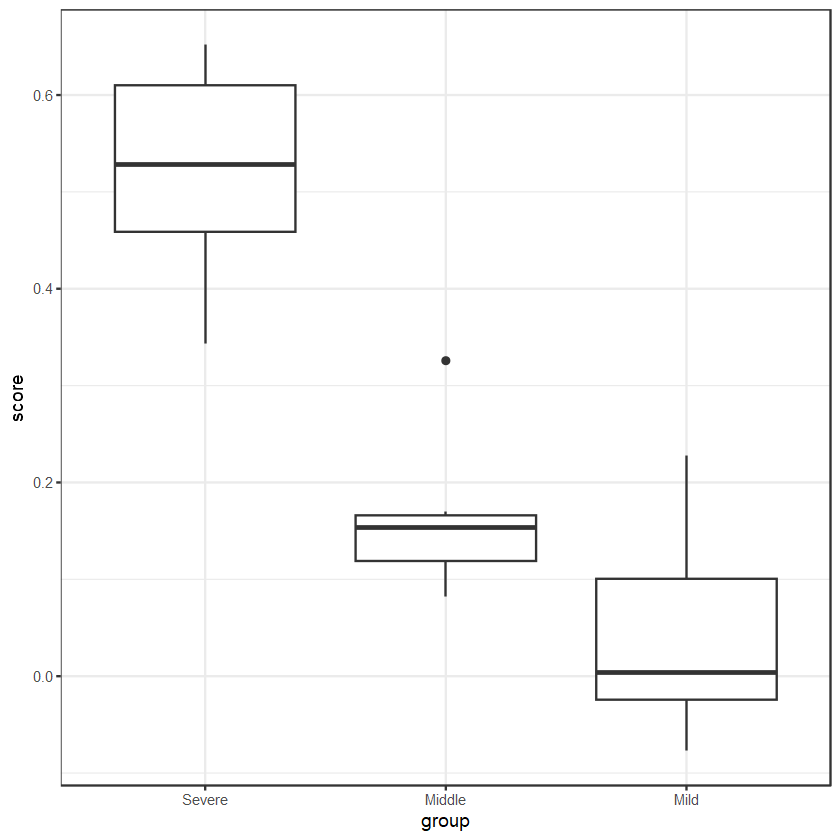

In [75]:
library(agricolae)
LSD.test(aov(score ~group, score), "group", group = T, console = T)
score$group = factor(score$group, levels = c("Severe", "Middle", "Mild"))
ggplot(score, aes(group, score)) +
    geom_boxplot() +
    theme_bw()

## Make object

In [21]:
met_tab = read.csv("data/RandomForest/met_tab.csv",row.names = 1)
sp_tab = read.csv("data/RandomForest/sp_tab.csv",row.names = 1) 
colnames(sp_tab) = gsub("s__", "", colnames(sp_tab))

In [ ]:
gene_tab = read.csv("gene_table.csv")
gene1 = gene_tab[,-1] %>% t
colnames(gene1) = gene_tab$gene1
gene_tab = gene1 %>% scale

In [ ]:
link = read.csv("data/RandomForest/link.csv") %>% mutate(number = 1:nrow(link))

In [ ]:
result_list = list()
for (i in 1:nrow(link)) {
    gene_name = link$HostGene[i]
    met_name = link$Metabolite[i]
    sp_name = link$Species[i]
    number = link$number[i]
    met_col = met_tab[, met_name]
    gene_col = gene_tab[,gene_name]
    sp_col = sp_tab[, sp_name]
    df = data.frame(cbind(met_col, gene_col, score$score, sp_col))
    colnames(df) = c(met_name, gene_name,"score", sp_name)
    result_list[[number]] = df
}

In [ ]:
result_list <- lapply(1:length(result_list), function(i) {
  read.csv(paste0("data/RandomForest/object/object_", i, ".csv"), header = T)
})

## RF

In [55]:
pacman::p_load(randomForest,rfPermute,rfUtilities,forcats)

In [65]:
result_list <- lapply(1:152, function(i) {
  read.csv(paste0("data/RandomForest/object/object_", i, ".csv"), header = T)
})

In [66]:
result = data.frame(number = integer(), Rsquare = numeric(), Pvalue = numeric())
for(i in 1:length(result_list)) {
    set.seed(1122)
    dff = result_list[i] 
    dff = as.data.frame(dff)
    model = randomForest(score~., data = dff, importance = TRUE,proximity = TRUE)
    treat = rf.significance(model, dff, nperm = 99, ntree = 500)
    result = rbind(result, data.frame(number = i, Rsquare = treat$Rsquare, Pvalue = treat$pValue))
    }

In [67]:
link = left_join(link, result, by = "number") %>% select(-number) 


In [ ]:
link %>% subset(Enriched.Group == "Severe") %>%
    arrange(desc(Rsquare)) 

Interaction,Enriched.Group,Species,Species_Pvalue,Species_LogFC,Metabolite,MetaB_Pvalue,MetaB_LogFC,HostGene,Gene_LogFC,Rsquare,Pvalue
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
Bacillus cereus_Xanthosine_nt5e,Severe,Bacillus cereus,0.001541051,5.578057,Xanthosine,0.04515,0.4726558,Nt5e,-0.0636126,0.58048073,0.010101
Bacillus cereus_Xanthosine_nt5m,Severe,Bacillus cereus,0.001541051,5.578057,Xanthosine,0.04515,0.4726558,Nt5m,0.1762341,0.57117521,0.010101
Bacillus cereus_Xanthosine_nt5el,Severe,Bacillus cereus,0.001541051,5.578057,Xanthosine,0.04515,0.4726558,Nt5el,-0.8602698,0.53848585,0.010101
Bacillus cereus_Xanthosine_nt5c2,Severe,Bacillus cereus,0.001541051,5.578057,Xanthosine,0.04515,0.4726558,Nt5c2,0.9945473,0.52192226,0.010101
Bacillus cereus_Xanthosine_Nt5dc2,Severe,Bacillus cereus,0.001541051,5.578057,Xanthosine,0.04515,0.4726558,Nt5dc2,-0.1557182,0.50997899,0.010101
Bacillus cereus_Xanthosine_nt5c1a,Severe,Bacillus cereus,0.001541051,5.578057,Xanthosine,0.04515,0.4726558,Nt5c1a,-0.6861859,0.50111126,0.010101
Bacillus cereus_Xanthosine_pnp2,Severe,Bacillus cereus,0.001541051,5.578057,Xanthosine,0.04515,0.4726558,Pnp2,0.1015200,0.46697135,0.010101
Fibrella_aestuarina_Xanthosine_nt5el,Severe,Fibrella_aestuarina,0.034778712,3.086297,Xanthosine,0.04515,0.4726558,Nt5el,-0.8602698,-0.03393466,0.222222
Fibrella_aestuarina_Xanthosine_nt5c2,Severe,Fibrella_aestuarina,0.034778712,3.086297,Xanthosine,0.04515,0.4726558,Nt5c2,0.9945473,-0.05843311,0.202020


In [73]:
write.csv(link %>% subset(Enriched.Group == "Severe") %>%
    arrange(desc(Rsquare)) , "data/RandomForest/link_RF.csv", row.names = FALSE)